In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_org')

In [5]:
df2 = df

In [5]:
import pyspark.sql.functions as F
df2 = df.select\
(['created_at', 'id_str', 'text', 'entities', 'user', 'retweeted_status', 'retweet_count', 'favorite_count', 'quote_count', 'lang',\
 F.col("user.screen_name").alias("name"), F.col("user.location").alias("location"), 
 F.col("user.favourites_count").alias('favorites_count2'),  F.col("user.followers_count").alias('followers_count2'),\
 F.col("user.statuses_count").alias('statuses_count2')])

In [6]:
df2 = df2.withColumn('verified', df2.user.verified)
df2 = df2.withColumn('description', df2.user.description)

In [7]:
df2 = df2.withColumn('description2', lower(df2.description))

In [8]:
df2 = df2.withColumn('organization', 
                F.when(df2.verified == 'false', 'Other') \
                .when( (df2.description2.contains('clinic')) \
                      | (df2.description2.contains('medic')) \
                      | (df2.description2.contains('nurse')) \
                      | (df2.description2.contains('health')) \
                      | (df2.description2.contains('doctor')) \
                      | (df2.description2.contains('md')), 'Health' ) \
                .when( (df2.description2.contains('democrat')) | (df2.description2.contains('republican')) | (df2.description2.contains('party')) \
                      | (df2.description2.contains('gov')) | (df2.description2.contains('senat')) \
                      | (df2.description2.contains('district')) | (df2.description2.contains('congress')) \
                      | (df2.description2.contains('chief')) | (df2.description2.contains('elect')), 'Governmental') \
                     .when(  (df2.description2.contains('news')) \
                      | (df2.description2.contains('journal')) | (df2.description2.contains('report')) | (df2.description2.contains('cover'))\
                                                                                                                          | (df2.description2.contains('times')) \
                                                                                                                          | (df2.description2.contains('post')) | (df2.description2.contains('magazine')) \
                                                                                                                          | (df2.description2.contains('station')) | (df2.description2.contains('tribune')) \
                                                                                                                          | (df2.description2.contains('pbs')) | (df2.description2.contains('insider')) \
                                                                                                                          | (df2.description2.contains('abc')) | (df2.description2.contains('media')) \
                                                                                                                          | (df2.description2.contains('gazette')) | (df2.description2.contains('edit')) \
                                                                                                                          | (df2.description2.contains('daily')) | (df2.description2.contains('column')), 'News')\
                     .when(df2.followers_count2 >= 30000, 'Celebrity').when(df2.followers_count2 >= 1000, 'Influencer')
                    
                ) 

In [9]:
df2 = df2.fillna({'organization' : 'Other'})

In [6]:
original_df = df2.filter(df2.retweeted_status.isNull())

In [7]:
df_infl = original_df.filter(original_df.organization == 'Influencer')

In [9]:
df_text_raw = df_infl.select(["text"])

In [10]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [11]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [12]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [13]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [14]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [15]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [16]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [17]:
df_dups_30 = df_dups_text

In [ ]:
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.0,3034,3036,[#AndinaEnglish P...,[#AndinaEnglish P...
0.0,3031,3059,[#AndinaEnglish ?...,[#AndinaEnglish P...
0.0,35325,37477,[Are COVID-19 boo...,[Are COVID-19 boo...
0.0,21273,36797,[It’s easy for us...,[It’s easy for us...
0.19999999999999996,15886,38533,[There are two es...,[There are two es...
0.0,26384,41591,[There are two es...,[There are two es...
0.0,4226,45734,"[5,745 new Covid-...",[#Rajasthan #Coro...
0.0,36821,36824,[#COVID19 Faridab...,[#COVID19 Faridab...
0.0,3903,4247,"[5,434 new Covid-...","[5,403 new Covid-..."
0.0,4016,4196,"[5,291 new Covid-...","[6,243 new Covid-..."


In [28]:
records = df_hashed_text.count()

In [29]:
dups = df_dups_text.select('id_A').distinct().count()

In [30]:
uniques = records - dups

In [31]:
dups = dups/records * 100 

In [32]:
uniques = uniques/records * 100

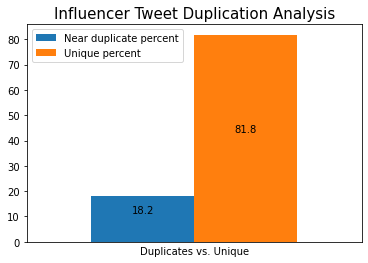

In [39]:
dups_df = pd.DataFrame.from_dict({'Near duplicate percent': [dups], 'Unique percent': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['Near duplicate percent', 'Unique percent'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Influencer Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
       ax.set_xticks([])